In [1]:
!pip install transformers datasets sentence-transformers scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install huggingface_hub[hf_xet]


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Numérico e dados
import numpy as np
import pandas as pd
import torch

# Transformers / Hugging Face
from transformers import AutoTokenizer, AutoModel

# Scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Visualização
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import json
import seaborn as sns

seed = 42

D:\Codigos\PlnAtividade1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

def mean_pooling(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = torch.sum(last_hidden_state * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts

@torch.no_grad()
def encode_sentences(model, tokenizer, sentences, pooling="mean", batch_size=32):
    """
    Usa um modelo e tokenizer carregados para gerar embeddings.
    (Mudei o pooling padrão para 'mean', que costuma ser melhor para
     similaridade do que 'cls' em BERTs-base)
    """
    device = next(model.parameters()).device
    all_vecs = []

    # Adiciona uma barra de progresso simples
    for i in range(0, len(sentences), batch_size):
        print(f"  Processando batch {i//batch_size + 1}/{(len(sentences)-1)//batch_size + 1}", end="\r")
        batch = sentences[i:i+batch_size]

        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
        outputs = model(**inputs)

        if pooling == "cls":
            vecs = outputs.last_hidden_state[:, 0, :]
        elif pooling == "mean":
            vecs = mean_pooling(outputs.last_hidden_state, inputs["attention_mask"])

        all_vecs.append(vecs.cpu().numpy())

    print("\n  Batch processing done.")
    return np.vstack(all_vecs)

In [5]:
# --- Função de Processamento de JSON (do nosso script TF-IDF) ---

def process_json_to_corpus(data, top_level_key):
    """
    Processa o JSON carregado e cria "documentões" (um por Raça/Classe).
    """
    corpus = []
    doc_labels = []

    if top_level_key not in data:
        print(f"Erro: Chave '{top_level_key}' não encontrada no JSON.")
        return corpus, doc_labels

    for label, snippets in data[top_level_key].items():
        # Desta vez NÃO removemos pontuação, BERT prefere texto natural
        snippets_limpas = [s.strip() for s in snippets if s and s.strip()]

        # Junta todos os snippets em um "documentão"
        full_document = " ".join(snippets_limpas)

        if full_document:
            corpus.append(full_document)
            doc_labels.append(label.capitalize())
        else:
            print(f"Aviso: Documento '{label}' estava vazio.")

    return corpus, doc_labels

In [6]:
# --- 1. Carregar Dados ---
filepath = 'JsonSoup\\JsonUnion\\resultado_unificado.json'
try:
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
except Exception as e:
    print(f"Erro ao carregar o JSON: {e}")
    # Se der erro aqui, não adianta continuar
    exit()

# --- 2. Criar os "Documentões" ---
print("--- Processando RAÇAS ---")
corpus_races, labels_races = process_json_to_corpus(data, "races")
print(f"Corpus de Raças criado com {len(corpus_races)} documentos.")

print("\n--- Processando CLASSES ---")
corpus_classes, labels_classes = process_json_to_corpus(data, "classes")
print(f"Corpus de Classes criado com {len(corpus_classes)} documentos.")

# --- 3. Definir Modelos BERT ---
modelos = {
    # 'mBERT' é bom, mas 'sentence-transformers' é otimizado para isso.
    # Vamos usar um modelo S-BERT (Sentence-BERT) que é leve e excelente para similaridade
    "MiniLM-L6": "sentence-transformers/all-MiniLM-L6-v2",

    # Se quiser testar com os seus:
    # "mBERT": "bert-base-multilingual-cased",
    # "BERTUncased": "google-bert/bert-base-uncased",
}

# (Se 'sentence-transformers' não estiver instalado, rode isso numa célula)
# !pip install sentence-transformers

--- Processando RAÇAS ---
Corpus de Raças criado com 9 documentos.

--- Processando CLASSES ---
Corpus de Classes criado com 13 documentos.



Usando device: cpu

--- Carregando Modelo: MiniLM-L6 ---

Gerando embeddings BERT para 9 Raças...
  Processando batch 1/1
  Batch processing done.
Gerando Heatmap de Raças (BERT)...


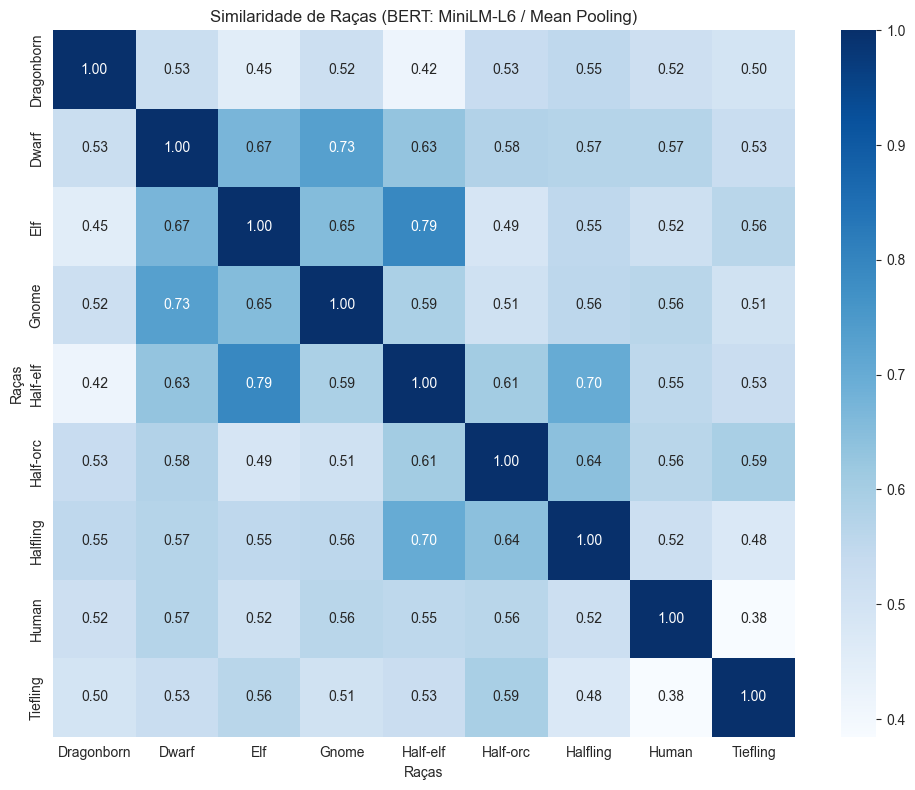

In [7]:
# --- 4. Loop de Processamento e Plotagem ---

device = get_device()
print(f"\nUsando device: {device}")

for nome_visivel, nome_hf in modelos.items():
    print(f"\n--- Carregando Modelo: {nome_visivel} ---")

    # Carrega o modelo e o tokenizer
    tokenizer = AutoTokenizer.from_pretrained(nome_hf)
    model = AutoModel.from_pretrained(nome_hf).to(device)
    model.eval()

    # --- Processar RAÇAS ---
    print(f"\nGerando embeddings BERT para {len(labels_races)} Raças...")
    embeds_races = encode_sentences(model, tokenizer, corpus_races, pooling="mean")

    # Calcular Similaridade
    sim_matrix_races = cosine_similarity(embeds_races)
    df_sim_races = pd.DataFrame(sim_matrix_races, index=labels_races, columns=labels_races)

    # Plotar Heatmap (usando Seaborn, mais direto)
    print("Gerando Heatmap de Raças (BERT)...")
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df_sim_races,
        annot=True,
        cmap="Blues",
        fmt=".2f"
    )
    plt.title(f"Similaridade de Raças (BERT: {nome_visivel} / Mean Pooling)")
    plt.xlabel("Raças")
    plt.ylabel("Raças")
    plt.tight_layout()
    plt.show()


Gerando embeddings BERT para 13 Classes...
  Processando batch 1/1
  Batch processing done.
Gerando Heatmap de Classes (BERT)...


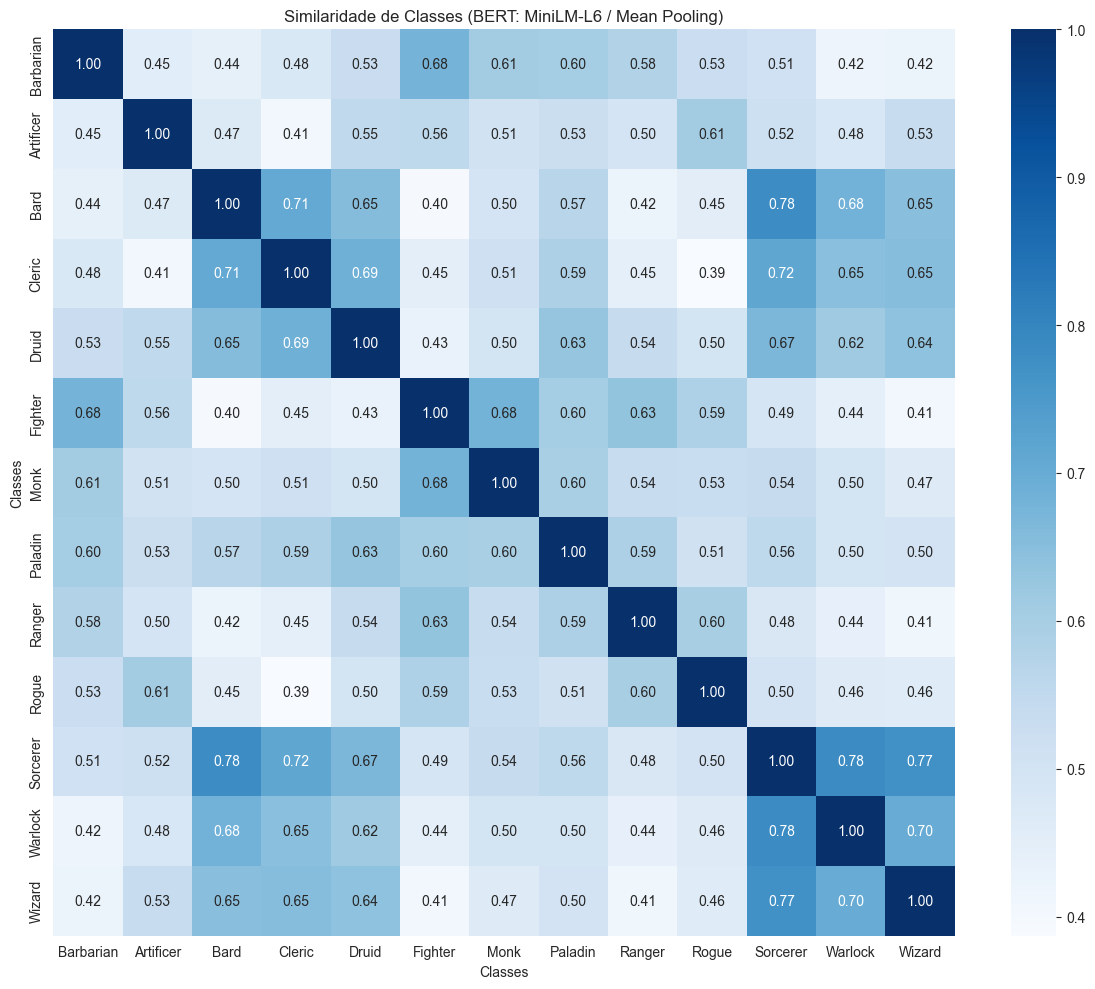

In [8]:
# --- Processar CLASSES ---
print(f"\nGerando embeddings BERT para {len(labels_classes)} Classes...")
embeds_classes = encode_sentences(model, tokenizer, corpus_classes, pooling="mean")

# Calcular Similaridade
sim_matrix_classes = cosine_similarity(embeds_classes)
df_sim_classes = pd.DataFrame(sim_matrix_classes, index=labels_classes, columns=labels_classes)

    # Plotar Heatmap
print("Gerando Heatmap de Classes (BERT)...")
plt.figure(figsize=(12, 10))
sns.heatmap(
    df_sim_classes,
    annot=True,
    cmap="Blues",
    fmt=".2f"
)
plt.title(f"Similaridade de Classes (BERT: {nome_visivel} / Mean Pooling)")
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

In [9]:
# --- Limpar Memória ---
"""del model, tokenizer, embeds_races, embeds_classes
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n--- Processamento BERT Concluído ---")"""

'del model, tokenizer, embeds_races, embeds_classes\nif torch.cuda.is_available():\n    torch.cuda.empty_cache()\n\nprint("\n--- Processamento BERT Concluído ---")'

# **Análise da Similaridade de Classes**

**O "Grupo dos Magos Arcanos" (Cluster de Alto Carisma/Inteligência):**

Bard & Sorcerer (0.78), Sorcerer & Warlock (0.78), Sorcerer & Wizard (0.77).

O BERT percebeu que, embora usem atributos diferentes (Carisma/Inteligência), as descrições de "Bardo", "Feiticeiro", "Bruxo" e "Mago" são semanticamente idênticas: todas falam sobre "conjuração" (spellcasting), "magias" (spells), "truques" (cantrips) e "espaços de magia" (spell slots). Ele agrupou os "conjuradores puros" de forma brilhante.


**O "Grupo dos Combatentes" (Cluster Marcial):**

Barbarian & Fighter (0.68).

O modelo uniu os dois "guerreiros" puros (não-mágicos). Suas descrições são focadas em "armas", "armaduras", "pontos de vida" (hit points), "Força" e "combate".

**A "Dupla Divina" (Cluster de Sabedoria):**

Cleric & Druid (0.69).

Ele também separou os "conjuradores divinos". Clérigos e Druidas são ambos baseados em "Sabedoria" (Wisdom) e têm descrições focadas em "magia divina", "cura" e sua conexão com um poder maior (divindade ou natureza).


**As Oposições Mais Fortes**

Barbarian vs. Wizard (0.42)

Fighter vs. Wizard (0.41)

O modelo concluiu que as classes mais diferentes de todas são o Bárbaro (pura força bruta, sem magia) e o Guerreiro (pura técnica marcial, sem magia) contra o Mago (pura magia, sem força).

**Os "Híbridos" (Meio-Termo)**

Paladin: tem alta similaridade com Fighter (0.60) e Cleric (0.59).

Ranger: tem alta similaridade com Fighter (0.59) e Druid (0.54).

# **Análise da Similaridade das Raças**

As descrições das raças (Idade, Tamanho, Alinhamento) são muito mais padronizadas do que as das classes.

**A Conexão Óbvia:**

Elf & Half-Elf (0.79).

O Meio-Elfo herda traços como "Visão no Escuro" (Darkvision) e "Ancestralidade Feérica" (Fey Ancestry).

**O "Grupo dos Pequeninos" (Underground Folk):**

Dwarf & Gnome (0.73).

Anões e Gnomos são as raças "pequenas e robustas que vivem debaixo da terra ou em colinas". Suas descrições compartilham conceitos como "Visão no Escuro", "viver no subterrâneo" e referências a "pedras" e "rochas" (Stonecunning / Rock Gnome).

**O "Grupo dos Exóticos":**

Half-Elf & Halfling (0.70)

Half-Orc & Halfling (0.64)

Provavelmente o BERT detectou uma semelhança estrutural na descrição: ambas as descrições falam sobre "alguns são assim (caseiros/chefes orcs), enquanto outros se tornam aventureiros e viajam pelo mundo".

**As Oposições Mais Fortes (Branco/Azul Claro)**

Human & Tiefling (0.38).

O Human é descrito como o "padrão", "jovens", "inovadores", "ambiciosos", sem alinhamento fixo. O Tiefling é descrito como o oposto: um "pária", recebido com "medo e desconfiança", resultado de um "pacto antigo", com uma "herança infernal" (Asmodeus, Nove Infernos).

Tiefling & Halfling (0.48).

O Halfling (conforto, lar, paz, bondade) é o oposto semântico do Tiefling (desconfiança, inferno, tormento).

In [10]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def recomendar_personagem(input_texto, top_k=3):
    #gera embemding do input
    embebed = encode_sentences(model, tokenizer, [input_texto], pooling="mean")

    #calcula similiaridade entre input e as classes
    sim_classes = cosine_similarity(embebed, embeds_classes)[0]
    top_classes = np.argsort(sim_classes)[::-1][:top_k] #pega os top 3 classes mais proximas do input fornecido
    piores_classes = np.argsort(sim_classes)[:top_k] #pega os 3 itens com pior similiaridade

    print("Classes mais indicadas:")
    for i in top_classes:
        print(f"{labels_classes[i]} - {sim_classes[i] * 100:.2f}%")

    print("-----")
    print("Classes menos inidcadas")
    for i in piores_classes:
        print(f"{labels_classes[i]} - {sim_classes[i] * 100:.2f}%")

    #calcula similiaridade, mesma coisa da linha 10 porem com as racas
    sim_races = cosine_similarity(embebed, embeds_races)[0]
    top_races = np.argsort(sim_races)[::-1][:top_k]
    piores_racas = np.argsort(sim_races)[:top_k]

    print("=====================")
    print("Racas mais indicadas:")
    for i in top_races:
        print(f"{labels_races[i]} - {sim_races[i] * 100:.2f}%")

    print("-----")
    print("Racas menos indicadas")
    for i in piores_racas:
        print(f"{labels_races[i]} - {sim_races[i] * 100:.2f}%")

texto = "wizard who can cast spells"
recomendar_personagem(texto)

  Processando batch 1/1
  Batch processing done.
Classes mais indicadas:
Wizard - 44.46%
Sorcerer - 40.86%
Cleric - 35.13%
-----
Classes menos inidcadas
Fighter - 0.53%
Rogue - 2.62%
Ranger - 2.89%
Racas mais indicadas:
Tiefling - 21.59%
Elf - 17.02%
Half-elf - 15.92%
-----
Racas menos indicadas
Half-orc - 5.08%
Human - 5.33%
Halfling - 7.18%
